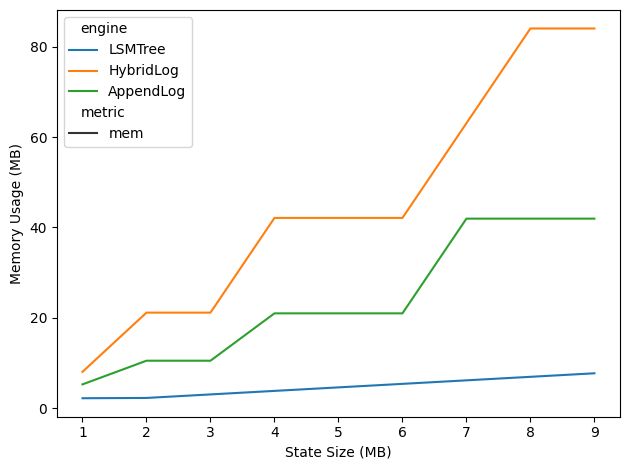

In [3]:
import sys
import pandas as pd
import seaborn as sns
from numpy import percentile
from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote
from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer
from utils import run


def measure_memory(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    for k, v in zip(keys_set, vals_set):
        db[k] = v
    
    res.append({'metric': 'mem', 'value': sys.getsizeof(db) / 1000_000})

    return res


df = run(
    [5], [5], list(range(100_000, 1_000_000, 100_000)), [0],
    [Uniform], [{'seed': [1]}],
    [LSMTree, HybridLog, AppendLog], [{
        'max_runs_per_level': [10],
        'density_factor': [10],
        'memtable_bytes_limit': [100_000],
        'remote': [None]
    },
    {
        'max_runs_per_level': [10],
        'ro_lag_interval': [10_000],
        'flush_interval': [10_000],
        'hash_index': ['dict'],
        'remote': [None]
    },
    {
        'max_runs_per_level': [10],
        'threshold': [100_000],
        'compaction': [False],
        'remote': [None]
    }],
    [measure_memory], {}
)

data = df[['n_items', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['mem'])]
data['n_items'] = data['n_items'] / 100_000


lineplot(data=data, x='n_items', y='value', hue='engine', style='metric',
         filename='mem.pdf', xlabel='State Size (MB)',
         ylabel='Memory Usage (MB)')
